Experimento 5


In [1]:
import os
import random
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

output_dir = "/mnt/d/Documentos Gustavo/TCC/processed_heatmaps - Copia"

# Listar IDs dos pacientes
healthy_patients = [p for p in os.listdir(os.path.join(output_dir, "Healthy")) if os.path.isdir(os.path.join(output_dir, "Healthy", p))]
sick_patients = [p for p in os.listdir(os.path.join(output_dir, "Sick")) if os.path.isdir(os.path.join(output_dir, "Sick", p))]

# Garantir aleatoriedade na separação
random.seed(42)
random.shuffle(healthy_patients)
random.shuffle(sick_patients)

# Definir proporção (70% treino, 15% validação, 15% teste)
train_healthy, temp_healthy = train_test_split(healthy_patients, test_size=0.3, random_state=42)
val_healthy, test_healthy = train_test_split(temp_healthy, test_size=0.5, random_state=42)

train_sick, temp_sick = train_test_split(sick_patients, test_size=0.3, random_state=42)
val_sick, test_sick = train_test_split(temp_sick, test_size=0.5, random_state=42)

# Transformação das imagens
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Criar dataset completo
dataset = datasets.ImageFolder(root=output_dir, transform=transform)

# Função para obter índices de imagens pertencentes a pacientes específicos
def get_patient_indices(dataset, selected_patients, max_samples):
    indices = []
    for i, (path, _) in enumerate(dataset.samples):
        paciente_id = os.path.basename(os.path.dirname(path))  # Extrai "p01", "p02", etc.
        if paciente_id in selected_patients:
            indices.append(i)
    
    # Garantir que pegamos exatamente 'max_samples' aleatórios
    return random.sample(indices, min(max_samples, len(indices)))

# Obter os índices das imagens de acordo com os pacientes
train_indicesH = get_patient_indices(dataset, train_healthy, 500)
val_indicesH = get_patient_indices(dataset, val_healthy, 250)
test_indicesH = get_patient_indices(dataset, test_healthy, 250)

train_indicesS = get_patient_indices(dataset, train_sick, 500)
val_indicesS = get_patient_indices(dataset, val_sick, 250)
test_indicesS = get_patient_indices(dataset, test_sick, 250)

# Juntar Healthy + Sick para cada conjunto
train_indices = train_indicesH + train_indicesS
val_indices = val_indicesH + val_indicesS
test_indices = test_indicesH + test_indicesS

# Criando datasets e DataLoaders
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Exibir quantidades finais
print(f"Tamanho do conjunto de treino: {len(train_dataset)}")
print(f"Tamanho do conjunto de validação: {len(val_dataset)}")
print(f"Tamanho do conjunto de teste: {len(test_dataset)}")

Tamanho do conjunto de treino: 1000
Tamanho do conjunto de validação: 500
Tamanho do conjunto de teste: 500


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import numpy as np
from datetime import datetime

# Configurar uso de GPU (se disponível)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Definição do modelo ResNet-50 modificado
class ResNet50Modificada(nn.Module):
    def __init__(self):
        super(ResNet50Modificada, self).__init__()
        self.model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

        # Removemos a camada de saída original e adicionamos duas fully connected layers
        num_features = self.model.fc.in_features

        self.model.fc = nn.Sequential(
            nn.Linear(num_features, 4096),  # Primeira camada
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 1024),  # Segunda camada
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 2)  # Camada final (saída de 2 neurônios para classificação binária)
        )

    def forward(self, x):
        return self.model(x)

# Número de execuções e épocas
num_execucoes = 5
num_epochs = 10

# Listas para armazenar métricas de cada execução
accuracies = []
all_preds = []

total_start_time = datetime.now()
for execucao in range(num_execucoes):
    print(f"\n🚀 Treinando Execução {execucao+1}/{num_execucoes}...\n")

    modelo = ResNet50Modificada().to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(modelo.parameters(), lr=0.0001, weight_decay=1e-4)

    # Early Stopping Configuração
    best_val_loss = float('inf')
    patience = 3
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        modelo.train()
        train_loss = 0

        for imagens, labels in train_loader:
            imagens, labels = imagens.to(device), labels.to(device)
            optimizer.zero_grad()
            output = modelo(imagens)
            loss = loss_fn(output, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validação
        modelo.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for imagens, labels in val_loader:
                imagens, labels = imagens.to(device), labels.to(device)
                output = modelo(imagens)
                loss = loss_fn(output, labels)
                val_loss += loss.item()

                _, predicted = torch.max(output, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        accuracy = 100 * correct / total
        avg_val_loss = val_loss / len(val_loader)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss/len(train_loader):.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | Val Acc: {accuracy:.2f}%")

        # Early Stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(modelo.state_dict(), f"best_model_execucao_{execucao+1}.pth")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("🛑 Early Stopping ativado!")
                break

    # Avaliação no conjunto de teste
    modelo.load_state_dict(torch.load(f"best_model_execucao_{execucao+1}.pth"))
    modelo.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for imagens, labels in test_loader:
            imagens, labels = imagens.to(device), labels.to(device)
            output = modelo(imagens)
            _, preds = torch.max(output, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Armazenar predições para modelo médio
    all_preds.append(y_pred)

    # Armazenar acurácia
    acc = (np.array(y_true) == np.array(y_pred)).mean()
    accuracies.append(acc)
    print(f"✅ Execução {execucao+1} finalizada! Acurácia: {acc:.4f}")

    # 🚀 Liberação de memória após cada execução
    del modelo, optimizer, loss_fn
    torch.cuda.empty_cache()  # Libera memória da GPU

# Salvar predições e labels para análise posterior
np.save("all_preds.npy", all_preds)
np.save("y_true.npy", y_true)

total_end_time = datetime.now()
print(f"\n🎯 Treinamento completo! Tempo total: {total_end_time - total_start_time}")
print("\n🎯 Treinamento completo! Agora execute o Bloco 2 para calcular o modelo médio.")


🚀 Treinando Execução 1/5...

Epoch 1/10 | Train Loss: 0.4244 | Val Loss: 0.6546 | Val Acc: 80.60%
Epoch 2/10 | Train Loss: 0.0841 | Val Loss: 1.8281 | Val Acc: 61.20%
Epoch 3/10 | Train Loss: 0.0381 | Val Loss: 1.4370 | Val Acc: 67.20%
Epoch 4/10 | Train Loss: 0.0202 | Val Loss: 1.2064 | Val Acc: 74.00%
🛑 Early Stopping ativado!


/tmp/ipykernel_50508/269383919.py:101: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  modelo.load_state_dict(torch.load(f"best_model_execucao_{execucao+1}.pth"))


✅ Execução 1 finalizada! Acurácia: 0.7920

🚀 Treinando Execução 2/5...

Epoch 1/10 | Train Loss: 0.3912 | Val Loss: 0.7947 | Val Acc: 79.20%
Epoch 2/10 | Train Loss: 0.0318 | Val Loss: 1.0931 | Val Acc: 79.60%
Epoch 3/10 | Train Loss: 0.0114 | Val Loss: 2.0513 | Val Acc: 69.20%
Epoch 4/10 | Train Loss: 0.1311 | Val Loss: 2.9342 | Val Acc: 63.20%
🛑 Early Stopping ativado!
✅ Execução 2 finalizada! Acurácia: 0.8300

🚀 Treinando Execução 3/5...

Epoch 1/10 | Train Loss: 0.4063 | Val Loss: 1.1502 | Val Acc: 75.40%
Epoch 2/10 | Train Loss: 0.0253 | Val Loss: 2.5653 | Val Acc: 66.20%
Epoch 3/10 | Train Loss: 0.0476 | Val Loss: 1.5618 | Val Acc: 70.20%
Epoch 4/10 | Train Loss: 0.0142 | Val Loss: 1.3171 | Val Acc: 76.80%
🛑 Early Stopping ativado!
✅ Execução 3 finalizada! Acurácia: 0.8160

🚀 Treinando Execução 4/5...

Epoch 1/10 | Train Loss: 0.4539 | Val Loss: 1.1647 | Val Acc: 73.60%
Epoch 2/10 | Train Loss: 0.0494 | Val Loss: 0.9734 | Val Acc: 75.60%
Epoch 3/10 | Train Loss: 0.0079 | Val Loss


===== 📊 MÉTRICAS DO MODELO MÉDIO =====
✅ Accuracy: 0.8060
✅ Sensitivity (Recall): 0.7360
✅ Specificity: 0.8760
✅ Precision: 0.8558
✅ F1-score: 0.7914


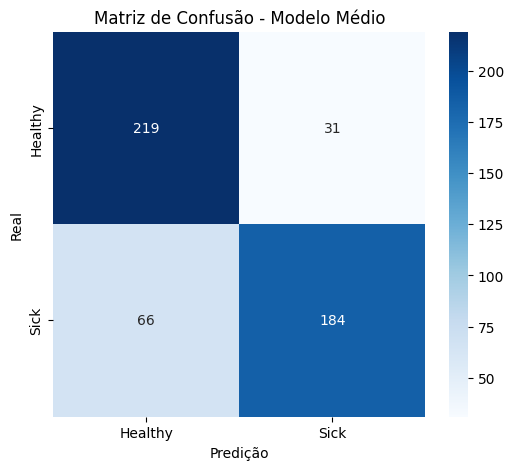

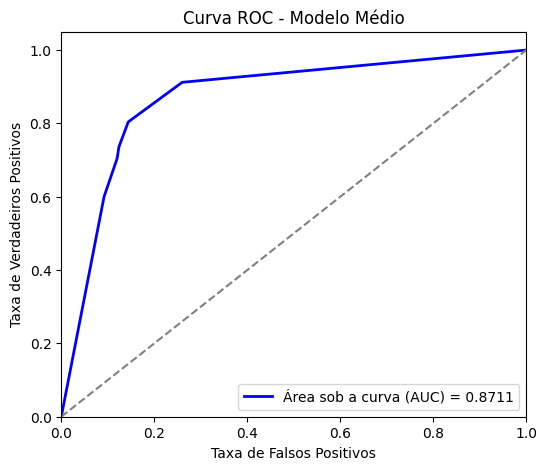

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

# Carregar predições salvas
all_preds = np.load("all_preds.npy")
y_true = np.load("y_true.npy")

# Calcular modelo médio por votação
final_preds = np.mean(np.array(all_preds), axis=0).round().astype(int)

# Gerar matriz de confusão
conf_matrix_final = confusion_matrix(y_true, final_preds)
tn, fp, fn, tp = conf_matrix_final.ravel()

# Calcular métricas do modelo médio
accuracy_final = accuracy_score(y_true, final_preds)
precision_final = precision_score(y_true, final_preds, average="binary")
recall_final = recall_score(y_true, final_preds, average="binary")
specificity_final = tn / (tn + fp)
f1_final = f1_score(y_true, final_preds, average="binary")

# Exibir métricas do modelo médio
print("\n===== 📊 MÉTRICAS DO MODELO MÉDIO =====")
print(f"✅ Accuracy: {accuracy_final:.4f}")
print(f"✅ Sensitivity (Recall): {recall_final:.4f}")
print(f"✅ Specificity: {specificity_final:.4f}")
print(f"✅ Precision: {precision_final:.4f}")
print(f"✅ F1-score: {f1_final:.4f}")

# Exibir matriz de confusão
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_final, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Healthy", "Sick"],
            yticklabels=["Healthy", "Sick"])
plt.xlabel("Predição")
plt.ylabel("Real")
plt.title("Matriz de Confusão - Modelo Médio")
plt.show()

# Calcular curva ROC
fpr, tpr, _ = roc_curve(y_true, np.mean(np.array(all_preds), axis=0))
roc_auc = auc(fpr, tpr)

# Exibir curva ROC
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Área sob a curva (AUC) = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC - Modelo Médio')
plt.legend(loc='lower right')
plt.show()
